# Livrable 01 : Classification Binaire
## Groupe 01 :

*   MASSOUDI Ray-Hann
*   TARTE Antoine
*   SILVA RORIZ Catarina
*   PRUVOT Matias
*   MAZOUNI Chiraz


# Contexte :
<p align="justify">
TouNum se spécialise dans les services de numérisation de documents, couvrant à la fois les textes et les images. Leurs compétences sont fréquemment sollicitées par des entreprises cherchant à convertir leurs archives documentaires papier en format numérique. Face à la demande croissante de capacités en Machine Learning, TouNum souhaite élargir son offre de services. Plus précisément, leurs clients disposent de volumes importants de données nécessitant une numérisation, ce qui rend un service de catégorisation automatique extrêmement précieux.
Ne disposant pas d'expert en Machine Learning en interne, TouNum a fait appel à nous, des spécialistes en data science. Un premier contrat a été proposé pour développer une solution permettant de générer automatiquement des légendes descriptives pour les photographies, par le biais d'un processus appelé "captioning".

Le projet est ambitieux mais réalisable grâce à l'existence de techniques bien établies et efficaces. Cependant, deux principaux défis se présentent. Tout d'abord, la numérisation en série engendre des images de qualité variable, certaines étant floues ou présentant du bruit. Il sera crucial d'implémenter des méthodes de nettoyage pour améliorer leur qualité.
Deuxièm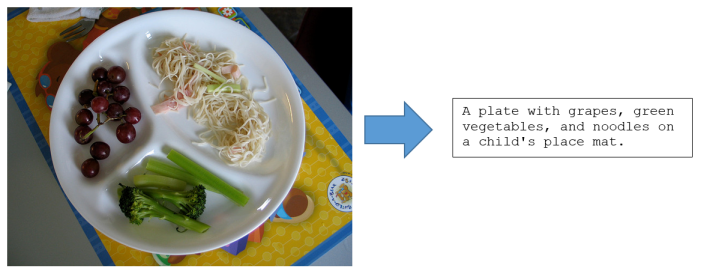ement, l'entreprise a déjà numérisé de nombreux documents, mais certains ne sont pas des photographies, mais plutôt des documents composés, schémas ou même des œuvres d'art. Il sera donc essentiel de distinguer ces types d'images avant l'analyse du contenu.
Fort heureusement, TouNum dispose d'une base de milliers d'images déjà catégorisées et étiquetées, une ressource précieuse pour l'apprentissage supervisé.


## Objectif
Notre mission consiste à concevoir une solution permettant d'analyser des photographies et de générer automatiquement des légendes descriptives, un processus communément appelé "captioning".
Nous utiliserons Python avec les bibliothèques SciKit et TensorFlow pour implémenter les algorithmes. De plus, la manipulation des jeux de données se fera à l'aide de la bibliothèque Pandas. ImageIO sera utilisé pour charger les images, et nous réutiliserons des bibliothèques bien connues telles que NumPy et MatPlotLib pour les calculs.
La classification binaire sera réalisée en utilisant des réseaux de neurones pour distinguer les photos des autres types d'images. L'objectif minimum est de différencier une photo d'un schéma ou d'un texte numérisé. Idéalement, l'algorithme pourra même discriminer entre des photos et des peintures, bien que cela soit plus complexe étant donné la similitude visuelle. TouNum a déjà classé un nombre considérable d'images, fournissant ainsi un ensemble de données catégorisées pour l'entraînement du réseau de neurones.
Le prétraitement reposera sur des concepts simples de filtres de convolution pour améliorer la qualité de l'image.
Quant au Captioning, qui englobe la génération automatique de légendes, il fera appel à deux techniques avancées de Machine Learning : les réseaux de neurones récurrents (RNN) et les réseaux de neurones convolutifs (CNN). Les RNN seront utilisés pour générer les légendes, mais il sera nécessaire de passer préalablement par les CNN pour prétraiter les images. Cela permettra d'identifier les zones d'intérêt dans les images et de représenter celles-ci de manière plus compacte. Cela évitera également des coûts élevés en performances liés au chargement de milliers d'images en mémoire. Pour l'apprentissage supervisé, nous nous appuierons sur des ensembles de données étiquetés classiques.
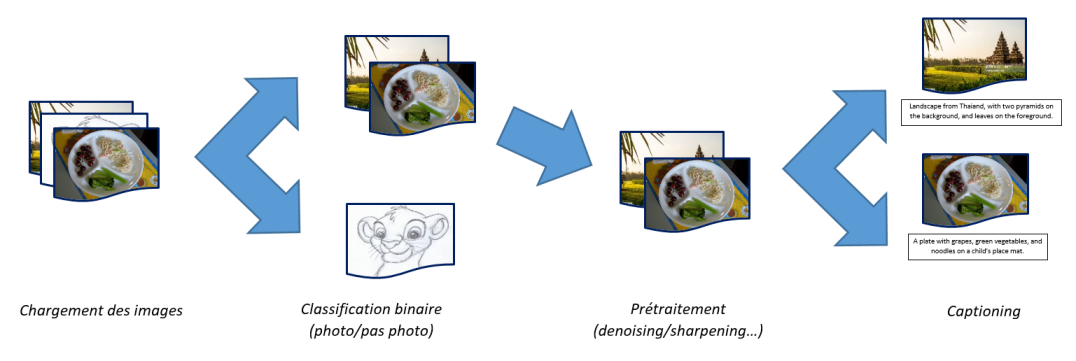

## Défis à Relever

1.	Qualité Variable des Images : Étant donné que la numérisation est effectuée en série et que les images peuvent présenter une qualité variable (floues, bruitées), une étape de prétraitement sera nécessaire pour améliorer la qualité des images avant l'analyse.
2.	Différenciation entre Types d'Images : Il est impératif de distinguer les photographies des autres types d'images (documents composés, schémas, dessins, peintures) afin de cibler uniquement les photographies pour l'analyse de contenu.
</p>

# Importation des librairie

On va d'abords installer un ensemble de librairies afin de nous assiter dans le development de notre solution

In [2]:
%pip install onedrivedownloader
from onedrivedownloader import download

  Using cached onedrivedownloader-1.1.3-py3-none-any.whl (5.1 kB)
Note: you may need to restart the kernel to use updated packages.


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from PIL import Image
import tensorflow as tf
import math

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split

import pandas as pd

import time
import requests

from tqdm import tqdm

%matplotlib inline

In [4]:
from mimetypes import guess_extension

In [5]:
%pip install tensorflow-cpu
%pip install tensorflow-directml-plugin

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Enable memory growth for each GPU
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

^C
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement tensorflow-directml-plugin (from versions: none)
ERROR: No matching distribution found for tensorflow-directml-plugin


Variable Definition

In [ ]:
# @title Variable Definition

image_h = 256 # @param {type:"number"}
image_w = 256 # @param {type:"number"}
data_dir = "data" # @param {type:"string"}
batch_s = 32 # @param {type:"number"}

# Telechargement des données

Le dataset étant lourd on a mis en place un telechargement automatisée de ce dernier (La source peut régulierement tombée mais restera un lien qui ne necessite pas de connexion préalable)

In [ ]:
# # https://store6.gofile.io/download/c4b6957a-77bb-423d-8d20-c4451ba505cf/ProjectDataset.zip
# import pathlib
# dataset_url = "https://store6.gofile.io/download/c4b6957a-77bb-423d-8d20-c4451ba505cf/ProjectDataset.zip"
# data_dir = tf.keras.utils.get_file('ProjectDataset', origin=dataset_url, extract=True)
# data_dir = pathlib.Path(data_dir)

In [ ]:
download(url="https://viacesifr-my.sharepoint.com/:u:/g/personal/rayhann_massoudi_viacesi_fr/EcKF-o75vKVMucKwLmMk6UIBUGDpDVI8vtjz9Sr57MhFqA?e=vsvgW3", filename="ProjectDataset.zip", unzip=True,unzip_path=data_dir)

Unzipping file...


Extracting files: 100%|██████████| 6/6 [00:12<00:00,  2.05s/it]


'data'

In [ ]:
import os
import glob

# Define the directory path
directory_path = data_dir+'/'

# Find all files containing '2' in their filenames in the specified directory
files_to_remove = glob.glob(os.path.join(directory_path, '*2*.zip'))

# Iterate through the list of files and remove them
for file_path in files_to_remove:
    try:
        os.remove(file_path)
        print(f"File {file_path} removed successfully.")
    except OSError as e:
        print(f"Error: {e} - {file_path}")

print("Removal process completed.")

File data\Dataset Livrable 2.zip removed successfully.
Removal process completed.


In [ ]:
import os, zipfile

extension = ".zip"

for item in os.listdir('./'+data_dir): # loop through items in dir
    if item.endswith(extension): # check for ".zip" extension
        file_name = os.path.abspath(data_dir+'/'+item) # get full path of files
        zip_ref = zipfile.ZipFile(file_name) # create zipfile object
        zip_ref.extractall(data_dir) # extract file to dir
        zip_ref.close() # close file
        os.remove(file_name) # delete zipped file

In [ ]:
# Get the list of class labels (subdirectories in the data directory)
class_labels = sorted(os.listdir(data_dir))
class_labels

['Painting', 'Photo', 'Schematics', 'Sketch', 'Text']

In [ ]:
def guess_image_mime_type(f):
    '''
    Function guesses an image mime type.
    Supported filetypes are JPG, BMP, PNG.
    '''
    with open(f, 'rb') as file:
        data = file.read(12)

    if data[:3] == b'\xff\xd8\xff':
        return 'image/jpeg'
    elif data[1:4] == b'PNG':
        return 'image/png'
    elif data[:2] == b'BM':
        return 'image/bmp'
    elif data[:3] == b'GIF':
        return 'image/gif'
    elif data[:4] == b'II*\x00' or data[:4] == b'MM\x00*':
        return 'image/tiff'
    elif data[:4] == b'RIFF' and data[8:12] == b'WEBP':
        return 'image/webp'
    else:
        return 'image/unknown-type'

In [ ]:
# Load images and labels into lists
image_paths = []
labels = []

# Iterate through the class labels and load images
for label in class_labels:
    print("Retriving "+ label +" Dataset")
    label_dir = os.path.join(data_dir, label)
    for filename in tqdm(os.listdir(label_dir)):

        image_path = os.path.join(label_dir, filename)
        trueExtension = guess_extension(guess_image_mime_type(image_path))
        
        if trueExtension == ".jpg" or trueExtension == ".png":  # Add more file extensions if necessary
            filenamewithoutExtension = filename.split('.')[0]
            truefilename = filenamewithoutExtension+trueExtension
            
            true_image_path = os.path.join(label_dir, truefilename)
            if(image_path != true_image_path):
                if os.path.exists(true_image_path):
                    os.remove(true_image_path)
                os.rename(image_path, true_image_path)
                print(image_path + " Changed to " + true_image_path)


            image_paths.append(true_image_path)
            labels.append((1 if label=='Photo' else 0))

# Create a DataFrame from the lists of image paths and labels
data = {'image_paths': image_paths, 'label': labels}
df = pd.DataFrame(data)


Retriving Painting Dataset


 13%|█▎        | 1286/10023 [00:02<00:11, 788.58it/s]

data\Painting\painting_01167.jpg Changed to data\Painting\painting_01167.png
data\Painting\painting_01314.jpg Changed to data\Painting\painting_01314.png
data\Painting\painting_01328.jpg Changed to data\Painting\painting_01328.png


 17%|█▋        | 1660/10023 [00:02<00:13, 601.82it/s]

data\Painting\painting_01542.jpg Changed to data\Painting\painting_01542.png


 22%|██▏       | 2231/10023 [00:04<00:18, 414.44it/s]

data\Painting\painting_02157.jpg Changed to data\Painting\painting_02157.png


 38%|███▊      | 3830/10023 [00:07<00:13, 471.99it/s]

data\Painting\painting_03763.jpg Changed to data\Painting\painting_03763.png


 50%|█████     | 5031/10023 [00:09<00:12, 403.35it/s]

data\Painting\painting_04963.jpg Changed to data\Painting\painting_04963.png


 52%|█████▏    | 5231/10023 [00:10<00:13, 357.05it/s]

data\Painting\painting_05169.jpg Changed to data\Painting\painting_05169.png


 60%|██████    | 6046/10023 [00:12<00:11, 360.13it/s]

data\Painting\painting_05970.jpg Changed to data\Painting\painting_05970.png


 63%|██████▎   | 6323/10023 [00:13<00:10, 357.95it/s]

data\Painting\painting_06265.jpg Changed to data\Painting\painting_06265.png


 65%|██████▌   | 6533/10023 [00:13<00:08, 431.69it/s]

data\Painting\painting_06433.jpg Changed to data\Painting\painting_06433.png
data\Painting\painting_06533.jpg Changed to data\Painting\painting_06533.png


 76%|███████▋  | 7651/10023 [00:15<00:02, 933.25it/s]

data\Painting\painting_07549.jpg Changed to data\Painting\painting_07549.png


 81%|████████▏ | 8148/10023 [00:16<00:02, 778.60it/s]

data\Painting\painting_08128.jpg Changed to data\Painting\painting_08128.png
data\Painting\painting_08211.jpg Changed to data\Painting\painting_08211.png


 85%|████████▌ | 8565/10023 [00:17<00:03, 411.13it/s]

data\Painting\painting_08498.jpg Changed to data\Painting\painting_08498.png
data\Painting\painting_08502.jpg Changed to data\Painting\painting_08502.png


 91%|█████████ | 9093/10023 [00:18<00:02, 387.06it/s]

data\Painting\painting_08997.jpg Changed to data\Painting\painting_08997.png


 93%|█████████▎| 9362/10023 [00:19<00:01, 628.95it/s]

data\Painting\painting_09284.jpg Changed to data\Painting\painting_09284.png


 96%|█████████▌| 9576/10023 [00:19<00:01, 413.91it/s]

data\Painting\painting_09480.jpg Changed to data\Painting\painting_09480.png


100%|█████████▉| 9984/10023 [00:20<00:00, 411.13it/s]

data\Painting\painting_09900.jpg Changed to data\Painting\painting_09900.png


100%|██████████| 10023/10023 [00:20<00:00, 482.18it/s]


Retriving Photo Dataset


100%|██████████| 9993/9993 [00:21<00:00, 462.43it/s]


Retriving Schematics Dataset


100%|██████████| 10001/10001 [00:15<00:00, 649.40it/s]


Retriving Sketch Dataset


100%|██████████| 1406/1406 [00:03<00:00, 383.27it/s]


Retriving Text Dataset


100%|██████████| 10000/10000 [00:18<00:00, 535.72it/s]


In [ ]:
len(image_paths)

41418

# Exploration du dataset

Maintenant que nous avons le dataset nous allons explorer son contenu

In [ ]:
df.head()

image_paths  label
0  data\Painting\painting_00001.jpg      0
1  data\Painting\painting_00002.jpg      0
2  data\Painting\painting_00003.jpg      0
3  data\Painting\painting_00004.jpg      0
4  data\Painting\painting_00005.jpg      0

# Pre-Traitement des données

On va affin de reussir a monter notre model avoir besoin de pretraiter les données pour cela nous allons utiliser un melange de tensorflow et de SciKit. Additionnelement les donnée seront traité par le model des que possible afin d'éviter des problemes d'incompatibilité et permettre de pre-traité les donnée de test même lors de la mise en production des données

## Chargement d'image
On creer qui permet de charger l'image à partir du chemin du fichier (le label est en parametre afin qu'elle puisse etre implémenter dans un map)

In [ ]:
def load_image(image_data):
    """
    La fonction load_image a pour entrée le chemin d'une image et pour sortie un couple
    contenant l'image traitée ainsi que son chemin d'accès.
    La fonction load_image effectue les traitement suivant:
        1. Chargement du fichier correspondant au chemin d'accès image_path
        2. Décodage de l'image en RGB.
    """

    # Chargement du fichier d'image
    img = tf.io.read_file(image_data['image'])

    # Décodage de l'image en RGB
    img = tf.image.decode_image(img, channels=3,expand_animations=False)
    
    img.set_shape([None,None,3])

    # # Rescale de l'image
    img = tf.image.resize(img, [image_h, image_w])
    
    # # Normalisation de l'image
    # img = img / 255

    return img, tf.cast( image_data['label'] , tf.int32)


On transforme notre dataframe en dataset a l'aide de la nouvelle fonction

In [ ]:
X_train_setdf, X_test_setdf, y_train_setdf, y_test_setdf = train_test_split(image_paths,labels, train_size=0.8, shuffle=True)

In [ ]:
X_train_setdf[0]

'data\\Photo\\photo_1609.jpg'

In [ ]:
X_test_setdf[0]

'data\\Schematics\\schematics_09280.jpg'

In [ ]:
y_train_setdf[0]

1

In [ ]:
y_test_setdf[0]

0

In [ ]:
train_set = tf.data.Dataset.from_tensor_slices({'image': X_train_setdf, 'label': y_train_setdf})

In [ ]:
test_set = tf.data.Dataset.from_tensor_slices({'image': X_test_setdf, 'label': y_test_setdf})

In [ ]:
train_set

<TensorSliceDataset element_spec={'image': TensorSpec(shape=(), dtype=tf.string, name=None), 'label': TensorSpec(shape=(), dtype=tf.int32, name=None)}>

In [ ]:
train_set_image = train_set.map(load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_s)
test_set_image = test_set.map(load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_s)

In [ ]:
train_set_image

<BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
test_set_image

<BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
train_set_image

<BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

# Modele building

In [ ]:
model_input = layers.Input(shape=(None, None, 3))
model = layers.Resizing(image_h,image_w)(model_input)
model = layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                     input_shape=(image_h, image_w, 3))(model)
model = layers.experimental.preprocessing.RandomRotation(0.20)(model)
model = layers.experimental.preprocessing.RandomZoom(0.2)(model)
model = layers.Rescaling(scale=1./255)(model)
model = layers.Conv2D(32, (3,3), strides=(3,3),input_shape=(image_h,image_w, 3) ,activation="relu")(model)
model = layers.Conv2D(64, (3,3), strides=(3,3), activation="relu")(model)
model = layers.Dropout(0.2, input_shape=(image_h,image_w, 3))(model)
model = layers.Flatten()(model)
model = layers.Dense(256, activation="relu")(model)
output = layers.Dense(1, activation="sigmoid")(model)



In [ ]:
model_binary_classification = keras.Model(model_input, output, name="binary_classification")

model_binary_classification.compile(
    optimizer='adam', 
    loss= "binary_crossentropy",
    metrics=['Recall']
)

model_binary_classification.build((None, None, 3))
model_binary_classification.summary()

Model: "binary_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 resizing (Resizing)         (None, 256, 256, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 85, 85, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 flatten (Flatten)           (None, 50176)             0         
                                                                 
 dense (Dense)               (None, 256)     

In [ ]:
epochs = 10
history = model_binary_classification.fit(
    train_set_image,
    validation_data = test_set_image,
    epochs = 10
  )

Epoch 1/10
1036/1036 [==============================] - 72s 67ms/step - loss: 0.3376 - recall: 0.6055 - val_loss: 0.2824 - val_recall: 0.5739
Epoch 2/10
 572/1036 [===============>..............] - ETA: 26s - loss: 0.2557 - recall: 0.7527

KeyboardInterrupt: 

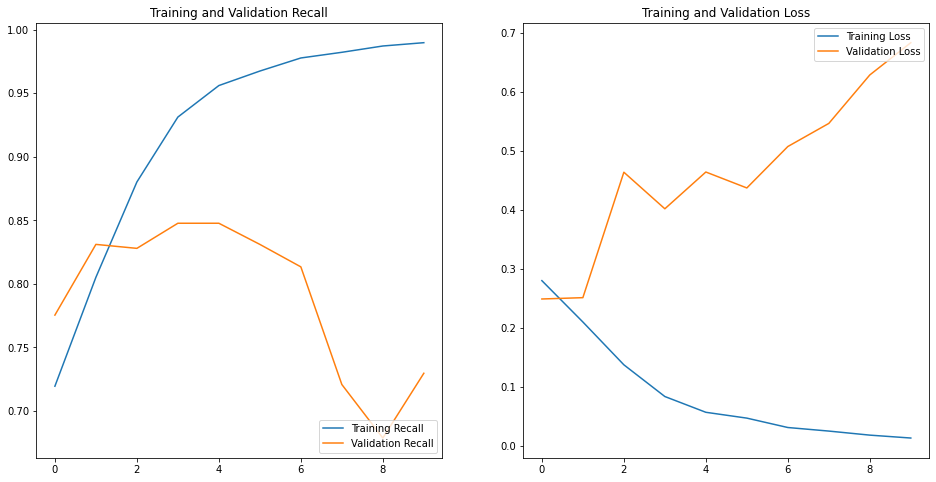

In [ ]:
rec = history.history['recall']
val_rec = history.history['val_recall']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, rec, label='Training Recall')
plt.plot(epochs_range, val_rec, label='Validation Recall')
plt.legend(loc='lower right')
plt.title('Training and Validation Recall')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
def SaveModel(model):
  name = input("Which name do you want to give to your model")
  filename = f"output/{name}.h5"
  os.makedirs(os.path.dirname(filename), exist_ok=True)
  model.save_weights(filename)

In [ ]:
SaveModel(model_binary_classification)